<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[22:10:34] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


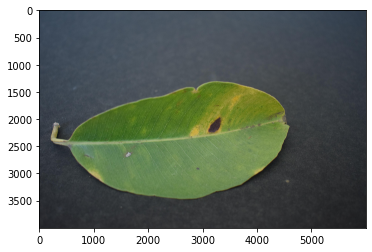

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

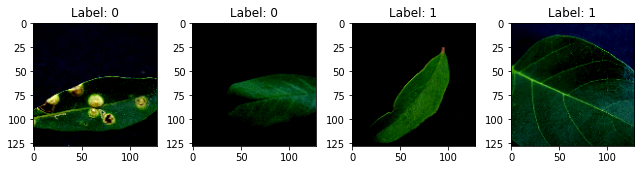

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[22:10:42] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[22:10:44] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.257006727675325 samples/sec                   batch loss = 0.382276326417923 | accuracy = 0.75


Epoch[1] Batch[10] Speed: 1.2648563101924228 samples/sec                   batch loss = 1.0150039196014404 | accuracy = 0.675


Epoch[1] Batch[15] Speed: 1.2656068505586267 samples/sec                   batch loss = 0.5978596210479736 | accuracy = 0.6833333333333333


Epoch[1] Batch[20] Speed: 1.2612113456892415 samples/sec                   batch loss = 0.5123077630996704 | accuracy = 0.6875


Epoch[1] Batch[25] Speed: 1.266878673746054 samples/sec                   batch loss = 1.852842092514038 | accuracy = 0.65


Epoch[1] Batch[30] Speed: 1.26203103968144 samples/sec                   batch loss = 0.9487435817718506 | accuracy = 0.6416666666666667


Epoch[1] Batch[35] Speed: 1.2627532332562033 samples/sec                   batch loss = 0.5729592442512512 | accuracy = 0.6571428571428571


Epoch[1] Batch[40] Speed: 1.2618530641906174 samples/sec                   batch loss = 0.6453941464424133 | accuracy = 0.65


Epoch[1] Batch[45] Speed: 1.2632831264382771 samples/sec                   batch loss = 0.3792620003223419 | accuracy = 0.6555555555555556


Epoch[1] Batch[50] Speed: 1.2668290258907162 samples/sec                   batch loss = 0.6735967993736267 | accuracy = 0.655


Epoch[1] Batch[55] Speed: 1.262261580688978 samples/sec                   batch loss = 0.37455692887306213 | accuracy = 0.6590909090909091


Epoch[1] Batch[60] Speed: 1.2625561462258545 samples/sec                   batch loss = 0.5281482338905334 | accuracy = 0.6708333333333333


Epoch[1] Batch[65] Speed: 1.2620629381939394 samples/sec                   batch loss = 0.45976507663726807 | accuracy = 0.6807692307692308


Epoch[1] Batch[70] Speed: 1.266234319542347 samples/sec                   batch loss = 0.49804574251174927 | accuracy = 0.675


Epoch[1] Batch[75] Speed: 1.268157656793502 samples/sec                   batch loss = 0.8748193979263306 | accuracy = 0.6766666666666666


Epoch[1] Batch[80] Speed: 1.2629466740298088 samples/sec                   batch loss = 0.5978001952171326 | accuracy = 0.675


Epoch[1] Batch[85] Speed: 1.2637918540447297 samples/sec                   batch loss = 0.24543876945972443 | accuracy = 0.6823529411764706


Epoch[1] Batch[90] Speed: 1.2587561845345672 samples/sec                   batch loss = 0.3318544328212738 | accuracy = 0.6833333333333333


Epoch[1] Batch[95] Speed: 1.2625669777627169 samples/sec                   batch loss = 0.443876177072525 | accuracy = 0.6842105263157895


Epoch[1] Batch[100] Speed: 1.254229971994931 samples/sec                   batch loss = 0.6718803644180298 | accuracy = 0.675


Epoch[1] Batch[105] Speed: 1.2608444415151794 samples/sec                   batch loss = 0.3692903220653534 | accuracy = 0.680952380952381


Epoch[1] Batch[110] Speed: 1.2729154068808017 samples/sec                   batch loss = 0.716980516910553 | accuracy = 0.6727272727272727


Epoch[1] Batch[115] Speed: 1.265422424803861 samples/sec                   batch loss = 0.7624534368515015 | accuracy = 0.6673913043478261


Epoch[1] Batch[120] Speed: 1.2684061684102963 samples/sec                   batch loss = 0.3715226650238037 | accuracy = 0.6625


Epoch[1] Batch[125] Speed: 1.2619737972872087 samples/sec                   batch loss = 0.6568249464035034 | accuracy = 0.664


Epoch[1] Batch[130] Speed: 1.2686934395320755 samples/sec                   batch loss = 0.46383360028266907 | accuracy = 0.6576923076923077


Epoch[1] Batch[135] Speed: 1.2669261250441572 samples/sec                   batch loss = 0.3777995705604553 | accuracy = 0.662962962962963


Epoch[1] Batch[140] Speed: 1.2607324507994166 samples/sec                   batch loss = 0.6636404395103455 | accuracy = 0.6642857142857143


Epoch[1] Batch[145] Speed: 1.2642514502496294 samples/sec                   batch loss = 0.49337249994277954 | accuracy = 0.6637931034482759


Epoch[1] Batch[150] Speed: 1.2714625025700612 samples/sec                   batch loss = 0.4816584587097168 | accuracy = 0.665


Epoch[1] Batch[155] Speed: 1.2647738298844184 samples/sec                   batch loss = 0.9711121320724487 | accuracy = 0.6645161290322581


Epoch[1] Batch[160] Speed: 1.2637199830823238 samples/sec                   batch loss = 1.12061607837677 | accuracy = 0.665625


Epoch[1] Batch[165] Speed: 1.2634101272272333 samples/sec                   batch loss = 0.43838778138160706 | accuracy = 0.6651515151515152


Epoch[1] Batch[170] Speed: 1.2697737641492013 samples/sec                   batch loss = 0.8914295434951782 | accuracy = 0.6661764705882353


Epoch[1] Batch[175] Speed: 1.259973674346697 samples/sec                   batch loss = 0.4112394452095032 | accuracy = 0.6671428571428571


Epoch[1] Batch[180] Speed: 1.26466094942047 samples/sec                   batch loss = 1.1302074193954468 | accuracy = 0.6625


Epoch[1] Batch[185] Speed: 1.2621519967428367 samples/sec                   batch loss = 0.3634594678878784 | accuracy = 0.6648648648648648


Epoch[1] Batch[190] Speed: 1.251787693511821 samples/sec                   batch loss = 0.39128297567367554 | accuracy = 0.6631578947368421


Epoch[1] Batch[195] Speed: 1.2558711989931002 samples/sec                   batch loss = 0.4398919343948364 | accuracy = 0.6628205128205128


Epoch[1] Batch[200] Speed: 1.255666762291803 samples/sec                   batch loss = 0.13514281809329987 | accuracy = 0.66625


Epoch[1] Batch[205] Speed: 1.2620236349002174 samples/sec                   batch loss = 0.4822636544704437 | accuracy = 0.6682926829268293


Epoch[1] Batch[210] Speed: 1.2609066987652489 samples/sec                   batch loss = 0.10593679547309875 | accuracy = 0.6726190476190477


Epoch[1] Batch[215] Speed: 1.258386459855011 samples/sec                   batch loss = 0.20700564980506897 | accuracy = 0.6744186046511628


Epoch[1] Batch[220] Speed: 1.2595516017991304 samples/sec                   batch loss = 0.371074378490448 | accuracy = 0.6727272727272727


Epoch[1] Batch[225] Speed: 1.2643901756708749 samples/sec                   batch loss = 1.0851997137069702 | accuracy = 0.6677777777777778


Epoch[1] Batch[230] Speed: 1.26080635106959 samples/sec                   batch loss = 0.4907863140106201 | accuracy = 0.6684782608695652


Epoch[1] Batch[235] Speed: 1.2638643996499161 samples/sec                   batch loss = 0.5007284283638 | accuracy = 0.6691489361702128


Epoch[1] Batch[240] Speed: 1.2620629381939394 samples/sec                   batch loss = 0.3856857419013977 | accuracy = 0.6708333333333333


Epoch[1] Batch[245] Speed: 1.259362697266902 samples/sec                   batch loss = 0.8965845704078674 | accuracy = 0.6724489795918367


Epoch[1] Batch[250] Speed: 1.2619644947020665 samples/sec                   batch loss = 0.4809246063232422 | accuracy = 0.671


Epoch[1] Batch[255] Speed: 1.2554043349615391 samples/sec                   batch loss = 0.7589641809463501 | accuracy = 0.6705882352941176


Epoch[1] Batch[260] Speed: 1.2600044280207798 samples/sec                   batch loss = 0.5201703310012817 | accuracy = 0.6711538461538461


Epoch[1] Batch[265] Speed: 1.2566313470694397 samples/sec                   batch loss = 0.3038065433502197 | accuracy = 0.6726415094339623


Epoch[1] Batch[270] Speed: 1.2607520619497197 samples/sec                   batch loss = 0.7541083097457886 | accuracy = 0.6731481481481482


Epoch[1] Batch[275] Speed: 1.2673361144822541 samples/sec                   batch loss = 0.5178008079528809 | accuracy = 0.6727272727272727


Epoch[1] Batch[280] Speed: 1.2626775840924391 samples/sec                   batch loss = 0.41003745794296265 | accuracy = 0.6732142857142858


Epoch[1] Batch[285] Speed: 1.2581658237756608 samples/sec                   batch loss = 0.4579008221626282 | accuracy = 0.6728070175438596


Epoch[1] Batch[290] Speed: 1.2623457282445487 samples/sec                   batch loss = 0.5659881830215454 | accuracy = 0.6732758620689655


Epoch[1] Batch[295] Speed: 1.2624479360743184 samples/sec                   batch loss = 0.8943435549736023 | accuracy = 0.673728813559322


Epoch[1] Batch[300] Speed: 1.2686108417533266 samples/sec                   batch loss = 0.6770347952842712 | accuracy = 0.675


Epoch[1] Batch[305] Speed: 1.2672579050775092 samples/sec                   batch loss = 0.42165136337280273 | accuracy = 0.6778688524590164


Epoch[1] Batch[310] Speed: 1.2667258205487055 samples/sec                   batch loss = 0.724760890007019 | accuracy = 0.6782258064516129


Epoch[1] Batch[315] Speed: 1.2616970565769503 samples/sec                   batch loss = 0.33725282549858093 | accuracy = 0.6793650793650794


Epoch[1] Batch[320] Speed: 1.2610395726967139 samples/sec                   batch loss = 0.10615380108356476 | accuracy = 0.68203125


Epoch[1] Batch[325] Speed: 1.2649666503832362 samples/sec                   batch loss = 0.6193466782569885 | accuracy = 0.6823076923076923


Epoch[1] Batch[330] Speed: 1.2627901107578443 samples/sec                   batch loss = 0.6814740896224976 | accuracy = 0.6825757575757576


Epoch[1] Batch[335] Speed: 1.2589055144183983 samples/sec                   batch loss = 0.45455512404441833 | accuracy = 0.682089552238806


Epoch[1] Batch[340] Speed: 1.2549561227299422 samples/sec                   batch loss = 0.5187817215919495 | accuracy = 0.6823529411764706


Epoch[1] Batch[345] Speed: 1.2584132660868104 samples/sec                   batch loss = 0.8433432579040527 | accuracy = 0.6804347826086956


Epoch[1] Batch[350] Speed: 1.2599482209027202 samples/sec                   batch loss = 0.22270455956459045 | accuracy = 0.6814285714285714


Epoch[1] Batch[355] Speed: 1.2617488650460507 samples/sec                   batch loss = 0.16874222457408905 | accuracy = 0.6838028169014084


Epoch[1] Batch[360] Speed: 1.2658840675786418 samples/sec                   batch loss = 0.30154499411582947 | accuracy = 0.6833333333333333


Epoch[1] Batch[365] Speed: 1.2612727858019965 samples/sec                   batch loss = 0.512605607509613 | accuracy = 0.6856164383561644


Epoch[1] Batch[370] Speed: 1.2634117446303998 samples/sec                   batch loss = 0.258368581533432 | accuracy = 0.6858108108108109


Epoch[1] Batch[375] Speed: 1.258881521017243 samples/sec                   batch loss = 0.5424224734306335 | accuracy = 0.6866666666666666


Epoch[1] Batch[380] Speed: 1.2536411316324922 samples/sec                   batch loss = 0.8789270520210266 | accuracy = 0.6875


Epoch[1] Batch[385] Speed: 1.2661869200507254 samples/sec                   batch loss = 0.9451900720596313 | accuracy = 0.6857142857142857


Epoch[1] Batch[390] Speed: 1.272422372957918 samples/sec                   batch loss = 0.5739386677742004 | accuracy = 0.6858974358974359


Epoch[1] Batch[395] Speed: 1.263233094187772 samples/sec                   batch loss = 0.286871075630188 | accuracy = 0.6848101265822785


Epoch[1] Batch[400] Speed: 1.262297764662483 samples/sec                   batch loss = 0.5160813331604004 | accuracy = 0.686875


Epoch[1] Batch[405] Speed: 1.262770721287427 samples/sec                   batch loss = 0.48927345871925354 | accuracy = 0.6882716049382716


Epoch[1] Batch[410] Speed: 1.2622949154554688 samples/sec                   batch loss = 0.4046582877635956 | accuracy = 0.6902439024390243


Epoch[1] Batch[415] Speed: 1.2579961998911255 samples/sec                   batch loss = 0.6557314991950989 | accuracy = 0.6903614457831325


Epoch[1] Batch[420] Speed: 1.257011342476374 samples/sec                   batch loss = 0.5130143165588379 | accuracy = 0.6904761904761905


Epoch[1] Batch[425] Speed: 1.260335621920708 samples/sec                   batch loss = 0.27401918172836304 | accuracy = 0.6923529411764706


Epoch[1] Batch[430] Speed: 1.2610298099640442 samples/sec                   batch loss = 0.776843786239624 | accuracy = 0.6918604651162791


Epoch[1] Batch[435] Speed: 1.2578742461342627 samples/sec                   batch loss = 0.15366746485233307 | accuracy = 0.6942528735632184


Epoch[1] Batch[440] Speed: 1.2646370221132621 samples/sec                   batch loss = 0.4953729212284088 | accuracy = 0.69375


Epoch[1] Batch[445] Speed: 1.2575698893507157 samples/sec                   batch loss = 0.3141574263572693 | accuracy = 0.6943820224719102


Epoch[1] Batch[450] Speed: 1.2603422494682284 samples/sec                   batch loss = 0.47715333104133606 | accuracy = 0.6933333333333334


Epoch[1] Batch[455] Speed: 1.2630080931751766 samples/sec                   batch loss = 0.6384875178337097 | accuracy = 0.6928571428571428


Epoch[1] Batch[460] Speed: 1.26112706490267 samples/sec                   batch loss = 0.5621473789215088 | accuracy = 0.6934782608695652


Epoch[1] Batch[465] Speed: 1.2632660998093115 samples/sec                   batch loss = 0.5732992887496948 | accuracy = 0.6946236559139785


Epoch[1] Batch[470] Speed: 1.2560249228311127 samples/sec                   batch loss = 1.0517840385437012 | accuracy = 0.6925531914893617


Epoch[1] Batch[475] Speed: 1.271712986025815 samples/sec                   batch loss = 0.588484525680542 | accuracy = 0.6931578947368421


Epoch[1] Batch[480] Speed: 1.271230033527247 samples/sec                   batch loss = 0.24296243488788605 | accuracy = 0.6958333333333333


Epoch[1] Batch[485] Speed: 1.2610883886276052 samples/sec                   batch loss = 0.15201036632061005 | accuracy = 0.6974226804123711


Epoch[1] Batch[490] Speed: 1.2626326360558142 samples/sec                   batch loss = 1.2813396453857422 | accuracy = 0.6974489795918367


Epoch[1] Batch[495] Speed: 1.2619368725278894 samples/sec                   batch loss = 0.3692449629306793 | accuracy = 0.697979797979798


Epoch[1] Batch[500] Speed: 1.2561378656637858 samples/sec                   batch loss = 0.19617561995983124 | accuracy = 0.6995


Epoch[1] Batch[505] Speed: 1.2621858954629828 samples/sec                   batch loss = 0.07441063225269318 | accuracy = 0.6995049504950495


Epoch[1] Batch[510] Speed: 1.260447163361751 samples/sec                   batch loss = 0.226065531373024 | accuracy = 0.6990196078431372


Epoch[1] Batch[515] Speed: 1.2562233621291832 samples/sec                   batch loss = 1.1124035120010376 | accuracy = 0.6980582524271844


Epoch[1] Batch[520] Speed: 1.2577499587490013 samples/sec                   batch loss = 0.2814370393753052 | accuracy = 0.6985576923076923


Epoch[1] Batch[525] Speed: 1.262045090018004 samples/sec                   batch loss = 0.7310823202133179 | accuracy = 0.6971428571428572


Epoch[1] Batch[530] Speed: 1.2620804071102876 samples/sec                   batch loss = 0.291156530380249 | accuracy = 0.6966981132075472


Epoch[1] Batch[535] Speed: 1.2637097028712287 samples/sec                   batch loss = 0.21453209221363068 | accuracy = 0.6953271028037383


Epoch[1] Batch[540] Speed: 1.2655702856944573 samples/sec                   batch loss = 0.838312566280365 | accuracy = 0.6953703703703704


Epoch[1] Batch[545] Speed: 1.2663386873829168 samples/sec                   batch loss = 0.8136425614356995 | accuracy = 0.694954128440367


Epoch[1] Batch[550] Speed: 1.2681424156165528 samples/sec                   batch loss = 0.3537517189979553 | accuracy = 0.6954545454545454


Epoch[1] Batch[555] Speed: 1.2625724886159602 samples/sec                   batch loss = 0.34232282638549805 | accuracy = 0.6972972972972973


Epoch[1] Batch[560] Speed: 1.2644821361506469 samples/sec                   batch loss = 0.11840110272169113 | accuracy = 0.6982142857142857


Epoch[1] Batch[565] Speed: 1.258546181456363 samples/sec                   batch loss = 0.4205820858478546 | accuracy = 0.6973451327433628


Epoch[1] Batch[570] Speed: 1.2609452691260883 samples/sec                   batch loss = 0.3349241614341736 | accuracy = 0.6973684210526315


Epoch[1] Batch[575] Speed: 1.25599445713582 samples/sec                   batch loss = 0.7262125015258789 | accuracy = 0.697391304347826


Epoch[1] Batch[580] Speed: 1.2536521854529499 samples/sec                   batch loss = 0.6876429319381714 | accuracy = 0.6974137931034483


Epoch[1] Batch[585] Speed: 1.261937252205936 samples/sec                   batch loss = 0.3687226474285126 | accuracy = 0.6965811965811965


Epoch[1] Batch[590] Speed: 1.2559822336611932 samples/sec                   batch loss = 0.4073166251182556 | accuracy = 0.6974576271186441


Epoch[1] Batch[595] Speed: 1.2653589573582462 samples/sec                   batch loss = 0.5063193440437317 | accuracy = 0.6978991596638655


Epoch[1] Batch[600] Speed: 1.2617392811074104 samples/sec                   batch loss = 0.22520573437213898 | accuracy = 0.69875


Epoch[1] Batch[605] Speed: 1.2557696772765126 samples/sec                   batch loss = 0.5012122392654419 | accuracy = 0.6987603305785124


Epoch[1] Batch[610] Speed: 1.2558734552176876 samples/sec                   batch loss = 0.2738974988460541 | accuracy = 0.7


Epoch[1] Batch[615] Speed: 1.2675845915014372 samples/sec                   batch loss = 0.500657856464386 | accuracy = 0.7008130081300813


Epoch[1] Batch[620] Speed: 1.2564529151511652 samples/sec                   batch loss = 0.3919728100299835 | accuracy = 0.7016129032258065


Epoch[1] Batch[625] Speed: 1.2588142687990427 samples/sec                   batch loss = 0.38780146837234497 | accuracy = 0.7032


Epoch[1] Batch[630] Speed: 1.2535715345118512 samples/sec                   batch loss = 0.7910436987876892 | accuracy = 0.7027777777777777


Epoch[1] Batch[635] Speed: 1.2591409627572407 samples/sec                   batch loss = 0.37385353446006775 | accuracy = 0.7015748031496063


Epoch[1] Batch[640] Speed: 1.2584381855800757 samples/sec                   batch loss = 0.4221911132335663 | accuracy = 0.701171875


Epoch[1] Batch[645] Speed: 1.2638902019975944 samples/sec                   batch loss = 0.32165253162384033 | accuracy = 0.7023255813953488


Epoch[1] Batch[650] Speed: 1.2654094444775472 samples/sec                   batch loss = 0.3762521743774414 | accuracy = 0.7023076923076923


Epoch[1] Batch[655] Speed: 1.2606930408641284 samples/sec                   batch loss = 0.3847810924053192 | accuracy = 0.7019083969465649


Epoch[1] Batch[660] Speed: 1.258855356027804 samples/sec                   batch loss = 0.6490622758865356 | accuracy = 0.7026515151515151


Epoch[1] Batch[665] Speed: 1.2581547845674832 samples/sec                   batch loss = 0.17056500911712646 | accuracy = 0.7022556390977444


Epoch[1] Batch[670] Speed: 1.256554076816505 samples/sec                   batch loss = 0.22756555676460266 | accuracy = 0.7033582089552238


Epoch[1] Batch[675] Speed: 1.254805382018886 samples/sec                   batch loss = 1.0462716817855835 | accuracy = 0.7037037037037037


Epoch[1] Batch[680] Speed: 1.2535906425075556 samples/sec                   batch loss = 0.27338680624961853 | accuracy = 0.7036764705882353


Epoch[1] Batch[685] Speed: 1.2603149822906878 samples/sec                   batch loss = 0.5427780747413635 | accuracy = 0.7043795620437956


Epoch[1] Batch[690] Speed: 1.263947999270736 samples/sec                   batch loss = 0.504125714302063 | accuracy = 0.7047101449275363


Epoch[1] Batch[695] Speed: 1.2678390103229649 samples/sec                   batch loss = 0.4321592450141907 | accuracy = 0.706115107913669


Epoch[1] Batch[700] Speed: 1.2659594327741714 samples/sec                   batch loss = 0.46170100569725037 | accuracy = 0.7078571428571429


Epoch[1] Batch[705] Speed: 1.26559520303576 samples/sec                   batch loss = 0.8045846819877625 | accuracy = 0.7078014184397163


Epoch[1] Batch[710] Speed: 1.2641095168733127 samples/sec                   batch loss = 0.8784035444259644 | accuracy = 0.7073943661971831


Epoch[1] Batch[715] Speed: 1.2611128454081373 samples/sec                   batch loss = 0.1978967785835266 | accuracy = 0.7083916083916084


Epoch[1] Batch[720] Speed: 1.2659621074960563 samples/sec                   batch loss = 0.39458420872688293 | accuracy = 0.7097222222222223


Epoch[1] Batch[725] Speed: 1.2657676464690162 samples/sec                   batch loss = 1.244998574256897 | accuracy = 0.7110344827586207


Epoch[1] Batch[730] Speed: 1.2654392232685157 samples/sec                   batch loss = 0.33726370334625244 | accuracy = 0.7109589041095891


Epoch[1] Batch[735] Speed: 1.2658748982812407 samples/sec                   batch loss = 0.4248976409435272 | accuracy = 0.7115646258503401


Epoch[1] Batch[740] Speed: 1.2687467836507176 samples/sec                   batch loss = 0.3324766457080841 | accuracy = 0.7114864864864865


Epoch[1] Batch[745] Speed: 1.258174221251779 samples/sec                   batch loss = 1.1572997570037842 | accuracy = 0.7110738255033557


Epoch[1] Batch[750] Speed: 1.2583649401854948 samples/sec                   batch loss = 0.357127845287323 | accuracy = 0.71


Epoch[1] Batch[755] Speed: 1.2550009952657366 samples/sec                   batch loss = 0.8481729626655579 | accuracy = 0.7109271523178808


Epoch[1] Batch[760] Speed: 1.2601011462814613 samples/sec                   batch loss = 0.8647601008415222 | accuracy = 0.7101973684210526


Epoch[1] Batch[765] Speed: 1.2634490411933155 samples/sec                   batch loss = 0.48724687099456787 | accuracy = 0.7094771241830066


Epoch[1] Batch[770] Speed: 1.2616251390518298 samples/sec                   batch loss = 0.4641781449317932 | accuracy = 0.7097402597402598


Epoch[1] Batch[775] Speed: 1.2635875905652336 samples/sec                   batch loss = 0.3695700466632843 | accuracy = 0.7093548387096774


Epoch[1] Batch[780] Speed: 1.269597537389344 samples/sec                   batch loss = 0.40097537636756897 | accuracy = 0.7112179487179487


Epoch[1] Batch[785] Speed: 1.2638981047723912 samples/sec                   batch loss = 0.7711518406867981 | accuracy = 0.7105095541401274


[Epoch 1] training: accuracy=0.7106598984771574
[Epoch 1] time cost: 651.3865866661072
[Epoch 1] validation: validation accuracy=0.7288888888888889


Epoch[2] Batch[5] Speed: 1.2648563101924228 samples/sec                   batch loss = 0.75605708360672 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2630242571010606 samples/sec                   batch loss = 0.4856565296649933 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.26121513811545 samples/sec                   batch loss = 0.5334769487380981 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2589272415155948 samples/sec                   batch loss = 0.46262773871421814 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2624794756605038 samples/sec                   batch loss = 0.5236285924911499 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2645661987774184 samples/sec                   batch loss = 0.4341295659542084 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.2700517522203856 samples/sec                   batch loss = 0.5057999491691589 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2677872753337505 samples/sec                   batch loss = 0.4154449999332428 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.2676357352770617 samples/sec                   batch loss = 0.6454055309295654 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2703805542277111 samples/sec                   batch loss = 1.0544097423553467 | accuracy = 0.715


Epoch[2] Batch[55] Speed: 1.2649507228229095 samples/sec                   batch loss = 0.931343674659729 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.264787178568809 samples/sec                   batch loss = 0.4349810481071472 | accuracy = 0.7166666666666667


Epoch[2] Batch[65] Speed: 1.261201959532454 samples/sec                   batch loss = 0.20749764144420624 | accuracy = 0.7192307692307692


Epoch[2] Batch[70] Speed: 1.2660456982506427 samples/sec                   batch loss = 0.7739682197570801 | accuracy = 0.7142857142857143


Epoch[2] Batch[75] Speed: 1.2639366679225261 samples/sec                   batch loss = 0.3754270374774933 | accuracy = 0.72


Epoch[2] Batch[80] Speed: 1.2655858469841395 samples/sec                   batch loss = 0.37540411949157715 | accuracy = 0.721875


Epoch[2] Batch[85] Speed: 1.2645201630974097 samples/sec                   batch loss = 0.17823129892349243 | accuracy = 0.7264705882352941


Epoch[2] Batch[90] Speed: 1.2583471020700094 samples/sec                   batch loss = 0.5668864250183105 | accuracy = 0.725


Epoch[2] Batch[95] Speed: 1.2706515904108808 samples/sec                   batch loss = 0.9084123373031616 | accuracy = 0.718421052631579


Epoch[2] Batch[100] Speed: 1.269842096407605 samples/sec                   batch loss = 0.18086907267570496 | accuracy = 0.7225


Epoch[2] Batch[105] Speed: 1.2623078319636125 samples/sec                   batch loss = 0.4435674846172333 | accuracy = 0.7261904761904762


Epoch[2] Batch[110] Speed: 1.2593357560428498 samples/sec                   batch loss = 0.7086567282676697 | accuracy = 0.7272727272727273


Epoch[2] Batch[115] Speed: 1.264388936916343 samples/sec                   batch loss = 0.26684799790382385 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2643476782483452 samples/sec                   batch loss = 0.6679137349128723 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.2596556274843003 samples/sec                   batch loss = 0.3662950098514557 | accuracy = 0.734


Epoch[2] Batch[130] Speed: 1.258618598162847 samples/sec                   batch loss = 0.19359207153320312 | accuracy = 0.7346153846153847


Epoch[2] Batch[135] Speed: 1.2622936808030905 samples/sec                   batch loss = 0.24257707595825195 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.2624961010766484 samples/sec                   batch loss = 0.46052655577659607 | accuracy = 0.7446428571428572


Epoch[2] Batch[145] Speed: 1.2570413866013717 samples/sec                   batch loss = 0.6948933005332947 | accuracy = 0.7413793103448276


Epoch[2] Batch[150] Speed: 1.2580239328154734 samples/sec                   batch loss = 0.1426224261522293 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2638533554245557 samples/sec                   batch loss = 0.6800251603126526 | accuracy = 0.75


Epoch[2] Batch[160] Speed: 1.2626620942385207 samples/sec                   batch loss = 0.569969892501831 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.2651972157422684 samples/sec                   batch loss = 0.6389585733413696 | accuracy = 0.7515151515151515


Epoch[2] Batch[170] Speed: 1.2568480556413113 samples/sec                   batch loss = 0.37224966287612915 | accuracy = 0.7544117647058823


Epoch[2] Batch[175] Speed: 1.2554562855480111 samples/sec                   batch loss = 0.25199687480926514 | accuracy = 0.7571428571428571


Epoch[2] Batch[180] Speed: 1.2615966779158905 samples/sec                   batch loss = 0.5927627086639404 | accuracy = 0.7597222222222222


Epoch[2] Batch[185] Speed: 1.248158771905548 samples/sec                   batch loss = 0.25950637459754944 | accuracy = 0.7594594594594595


Epoch[2] Batch[190] Speed: 1.261873659318806 samples/sec                   batch loss = 0.7550244331359863 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.2593156217754238 samples/sec                   batch loss = 0.2898993492126465 | accuracy = 0.7589743589743589


Epoch[2] Batch[200] Speed: 1.2578939570883514 samples/sec                   batch loss = 0.8713151812553406 | accuracy = 0.7525


Epoch[2] Batch[205] Speed: 1.2524176118837873 samples/sec                   batch loss = 0.3786645531654358 | accuracy = 0.7524390243902439


Epoch[2] Batch[210] Speed: 1.2508558936682546 samples/sec                   batch loss = 0.7197120189666748 | accuracy = 0.7511904761904762


Epoch[2] Batch[215] Speed: 1.258144500351259 samples/sec                   batch loss = 0.6567647457122803 | accuracy = 0.7488372093023256


Epoch[2] Batch[220] Speed: 1.2590363606700625 samples/sec                   batch loss = 1.3520667552947998 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.2659752902190424 samples/sec                   batch loss = 1.1814264059066772 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2685788032337644 samples/sec                   batch loss = 0.399434894323349 | accuracy = 0.7489130434782608


Epoch[2] Batch[235] Speed: 1.2619755059402047 samples/sec                   batch loss = 0.26157569885253906 | accuracy = 0.752127659574468


Epoch[2] Batch[240] Speed: 1.2643720710384523 samples/sec                   batch loss = 0.3179015815258026 | accuracy = 0.7541666666666667


Epoch[2] Batch[245] Speed: 1.2631444536196976 samples/sec                   batch loss = 0.9820981621742249 | accuracy = 0.7510204081632653


Epoch[2] Batch[250] Speed: 1.268742274172152 samples/sec                   batch loss = 0.3866852819919586 | accuracy = 0.753


Epoch[2] Batch[255] Speed: 1.265103052503476 samples/sec                   batch loss = 0.2055494487285614 | accuracy = 0.7519607843137255


Epoch[2] Batch[260] Speed: 1.2685498356660478 samples/sec                   batch loss = 0.3626367449760437 | accuracy = 0.7528846153846154


Epoch[2] Batch[265] Speed: 1.2594894782896449 samples/sec                   batch loss = 0.4403054714202881 | accuracy = 0.7547169811320755


Epoch[2] Batch[270] Speed: 1.266379693741899 samples/sec                   batch loss = 0.3857308626174927 | accuracy = 0.7546296296296297


Epoch[2] Batch[275] Speed: 1.2674239081404857 samples/sec                   batch loss = 0.3843814432621002 | accuracy = 0.7536363636363637


Epoch[2] Batch[280] Speed: 1.2704991724482204 samples/sec                   batch loss = 0.2542956471443176 | accuracy = 0.75625


Epoch[2] Batch[285] Speed: 1.272148458731268 samples/sec                   batch loss = 0.4543628394603729 | accuracy = 0.756140350877193


Epoch[2] Batch[290] Speed: 1.268071199123238 samples/sec                   batch loss = 0.6153355836868286 | accuracy = 0.7525862068965518


Epoch[2] Batch[295] Speed: 1.2663638261644592 samples/sec                   batch loss = 0.24554958939552307 | accuracy = 0.7542372881355932


Epoch[2] Batch[300] Speed: 1.2655497606522208 samples/sec                   batch loss = 0.8777985572814941 | accuracy = 0.7541666666666667


Epoch[2] Batch[305] Speed: 1.2682870777747741 samples/sec                   batch loss = 0.49501997232437134 | accuracy = 0.7540983606557377


Epoch[2] Batch[310] Speed: 1.2662183600430494 samples/sec                   batch loss = 1.8137215375900269 | accuracy = 0.7508064516129033


Epoch[2] Batch[315] Speed: 1.271684935453554 samples/sec                   batch loss = 0.3440694212913513 | accuracy = 0.7492063492063492


Epoch[2] Batch[320] Speed: 1.2684468292715383 samples/sec                   batch loss = 0.4421193301677704 | accuracy = 0.7484375


Epoch[2] Batch[325] Speed: 1.265781971126932 samples/sec                   batch loss = 0.36197736859321594 | accuracy = 0.7484615384615385


Epoch[2] Batch[330] Speed: 1.2663469075590736 samples/sec                   batch loss = 0.6594344973564148 | accuracy = 0.7492424242424243


Epoch[2] Batch[335] Speed: 1.2602371637104144 samples/sec                   batch loss = 0.42873913049697876 | accuracy = 0.7470149253731343


Epoch[2] Batch[340] Speed: 1.2743361111077354 samples/sec                   batch loss = 0.5377203226089478 | accuracy = 0.7463235294117647


Epoch[2] Batch[345] Speed: 1.2667855991655648 samples/sec                   batch loss = 0.39014509320259094 | accuracy = 0.7485507246376811


Epoch[2] Batch[350] Speed: 1.2665548370342299 samples/sec                   batch loss = 0.3049694299697876 | accuracy = 0.7492857142857143


Epoch[2] Batch[355] Speed: 1.2634161211538484 samples/sec                   batch loss = 0.6051450967788696 | accuracy = 0.747887323943662


Epoch[2] Batch[360] Speed: 1.259060926897659 samples/sec                   batch loss = 0.08845368772745132 | accuracy = 0.75


Epoch[2] Batch[365] Speed: 1.255586603676351 samples/sec                   batch loss = 0.32993200421333313 | accuracy = 0.7486301369863013


Epoch[2] Batch[370] Speed: 1.2535905488394892 samples/sec                   batch loss = 0.5803312063217163 | accuracy = 0.7486486486486487


Epoch[2] Batch[375] Speed: 1.2592968114687983 samples/sec                   batch loss = 0.326571524143219 | accuracy = 0.7473333333333333


Epoch[2] Batch[380] Speed: 1.2655051806446351 samples/sec                   batch loss = 0.9406135082244873 | accuracy = 0.7473684210526316


Epoch[2] Batch[385] Speed: 1.2632898801444967 samples/sec                   batch loss = 1.0604292154312134 | accuracy = 0.7474025974025974


Epoch[2] Batch[390] Speed: 1.2616766569736575 samples/sec                   batch loss = 0.3786855936050415 | accuracy = 0.7461538461538462


Epoch[2] Batch[395] Speed: 1.2672958119800477 samples/sec                   batch loss = 0.3473811745643616 | accuracy = 0.7462025316455696


Epoch[2] Batch[400] Speed: 1.2621243663599626 samples/sec                   batch loss = 0.15597139298915863 | accuracy = 0.746875


Epoch[2] Batch[405] Speed: 1.261959938383871 samples/sec                   batch loss = 0.2036554515361786 | accuracy = 0.7487654320987654


Epoch[2] Batch[410] Speed: 1.2680645858844015 samples/sec                   batch loss = 0.6556941866874695 | accuracy = 0.75


Epoch[2] Batch[415] Speed: 1.2616605275217734 samples/sec                   batch loss = 0.5468746423721313 | accuracy = 0.7512048192771085


Epoch[2] Batch[420] Speed: 1.2591658165761939 samples/sec                   batch loss = 0.380219042301178 | accuracy = 0.7505952380952381


Epoch[2] Batch[425] Speed: 1.257284900597684 samples/sec                   batch loss = 0.36409905552864075 | accuracy = 0.7517647058823529


Epoch[2] Batch[430] Speed: 1.2632629608719557 samples/sec                   batch loss = 0.8011676669120789 | accuracy = 0.752906976744186


Epoch[2] Batch[435] Speed: 1.2637609152111482 samples/sec                   batch loss = 0.32169798016548157 | accuracy = 0.7528735632183908


Epoch[2] Batch[440] Speed: 1.258969375328255 samples/sec                   batch loss = 0.44879087805747986 | accuracy = 0.7522727272727273


Epoch[2] Batch[445] Speed: 1.263242130137488 samples/sec                   batch loss = 0.457858145236969 | accuracy = 0.7522471910112359


Epoch[2] Batch[450] Speed: 1.2594946786528198 samples/sec                   batch loss = 0.7340371608734131 | accuracy = 0.7533333333333333


Epoch[2] Batch[455] Speed: 1.2651153587566693 samples/sec                   batch loss = 0.6843577027320862 | accuracy = 0.7532967032967033


Epoch[2] Batch[460] Speed: 1.268645567964333 samples/sec                   batch loss = 0.24251249432563782 | accuracy = 0.7548913043478261


Epoch[2] Batch[465] Speed: 1.2620012312195392 samples/sec                   batch loss = 0.5710721015930176 | accuracy = 0.7548387096774194


Epoch[2] Batch[470] Speed: 1.2565747816769683 samples/sec                   batch loss = 0.3035658001899719 | accuracy = 0.7558510638297873


Epoch[2] Batch[475] Speed: 1.2616474345052708 samples/sec                   batch loss = 0.539365828037262 | accuracy = 0.7557894736842106


Epoch[2] Batch[480] Speed: 1.2631721286845403 samples/sec                   batch loss = 0.6813457012176514 | accuracy = 0.7552083333333334


Epoch[2] Batch[485] Speed: 1.2587918844720487 samples/sec                   batch loss = 0.26818743348121643 | accuracy = 0.7546391752577319


Epoch[2] Batch[490] Speed: 1.2634204025648226 samples/sec                   batch loss = 0.28652897477149963 | accuracy = 0.7556122448979592


Epoch[2] Batch[495] Speed: 1.2597862513337703 samples/sec                   batch loss = 0.7619403600692749 | accuracy = 0.7555555555555555


Epoch[2] Batch[500] Speed: 1.2612359020532162 samples/sec                   batch loss = 0.36880621314048767 | accuracy = 0.7565


Epoch[2] Batch[505] Speed: 1.2582831155309828 samples/sec                   batch loss = 0.44040969014167786 | accuracy = 0.7579207920792079


Epoch[2] Batch[510] Speed: 1.2565521945902967 samples/sec                   batch loss = 0.8560835123062134 | accuracy = 0.7573529411764706


Epoch[2] Batch[515] Speed: 1.2604520875475893 samples/sec                   batch loss = 0.4095238447189331 | accuracy = 0.7577669902912622


Epoch[2] Batch[520] Speed: 1.257955828975995 samples/sec                   batch loss = 0.33121269941329956 | accuracy = 0.7572115384615384


Epoch[2] Batch[525] Speed: 1.2616997133180214 samples/sec                   batch loss = 0.079661063849926 | accuracy = 0.7571428571428571


Epoch[2] Batch[530] Speed: 1.2602443582124667 samples/sec                   batch loss = 0.29977884888648987 | accuracy = 0.7570754716981132


Epoch[2] Batch[535] Speed: 1.2662526686854094 samples/sec                   batch loss = 0.517823338508606 | accuracy = 0.7560747663551401


Epoch[2] Batch[540] Speed: 1.2619036515833877 samples/sec                   batch loss = 0.3826926648616791 | accuracy = 0.7564814814814815


Epoch[2] Batch[545] Speed: 1.268273271611546 samples/sec                   batch loss = 1.4663527011871338 | accuracy = 0.7555045871559632


Epoch[2] Batch[550] Speed: 1.264779646062264 samples/sec                   batch loss = 0.4792100787162781 | accuracy = 0.7559090909090909


Epoch[2] Batch[555] Speed: 1.2689608768446854 samples/sec                   batch loss = 0.1816064864397049 | accuracy = 0.7567567567567568


Epoch[2] Batch[560] Speed: 1.2721475905749917 samples/sec                   batch loss = 0.8001063466072083 | accuracy = 0.7566964285714286


Epoch[2] Batch[565] Speed: 1.2725528589594661 samples/sec                   batch loss = 0.3028625249862671 | accuracy = 0.7566371681415929


Epoch[2] Batch[570] Speed: 1.2670189332195898 samples/sec                   batch loss = 0.7067736983299255 | accuracy = 0.756578947368421


Epoch[2] Batch[575] Speed: 1.2645909812766514 samples/sec                   batch loss = 1.2751048803329468 | accuracy = 0.7543478260869565


Epoch[2] Batch[580] Speed: 1.2687285540408866 samples/sec                   batch loss = 0.40313979983329773 | accuracy = 0.7560344827586207


Epoch[2] Batch[585] Speed: 1.2693451974511132 samples/sec                   batch loss = 0.5513238310813904 | accuracy = 0.755982905982906


Epoch[2] Batch[590] Speed: 1.2738445876462432 samples/sec                   batch loss = 0.35299253463745117 | accuracy = 0.7572033898305085


Epoch[2] Batch[595] Speed: 1.2682721211115113 samples/sec                   batch loss = 0.3347705006599426 | accuracy = 0.7567226890756302


Epoch[2] Batch[600] Speed: 1.267479635180285 samples/sec                   batch loss = 0.4351954758167267 | accuracy = 0.7579166666666667


Epoch[2] Batch[605] Speed: 1.267256469254565 samples/sec                   batch loss = 0.3942217230796814 | accuracy = 0.7582644628099173


Epoch[2] Batch[610] Speed: 1.2651513249154382 samples/sec                   batch loss = 0.7095911502838135 | accuracy = 0.7577868852459017


Epoch[2] Batch[615] Speed: 1.2662676733278266 samples/sec                   batch loss = 0.278035044670105 | accuracy = 0.7577235772357723


Epoch[2] Batch[620] Speed: 1.2684193061865208 samples/sec                   batch loss = 0.8271156549453735 | accuracy = 0.7556451612903226


Epoch[2] Batch[625] Speed: 1.267419120822687 samples/sec                   batch loss = 0.5444680452346802 | accuracy = 0.7556


Epoch[2] Batch[630] Speed: 1.2686347278103882 samples/sec                   batch loss = 0.3633282482624054 | accuracy = 0.7555555555555555


Epoch[2] Batch[635] Speed: 1.2725156986079644 samples/sec                   batch loss = 0.8204567432403564 | accuracy = 0.7551181102362204


Epoch[2] Batch[640] Speed: 1.2692383170224024 samples/sec                   batch loss = 0.10141469538211823 | accuracy = 0.75546875


Epoch[2] Batch[645] Speed: 1.2697737641492013 samples/sec                   batch loss = 0.3729696571826935 | accuracy = 0.756201550387597


Epoch[2] Batch[650] Speed: 1.2645649596779542 samples/sec                   batch loss = 0.6184105277061462 | accuracy = 0.7553846153846154


Epoch[2] Batch[655] Speed: 1.2667688605841303 samples/sec                   batch loss = 0.2563855051994324 | accuracy = 0.7557251908396947


Epoch[2] Batch[660] Speed: 1.264627584898444 samples/sec                   batch loss = 0.6491531133651733 | accuracy = 0.7556818181818182


Epoch[2] Batch[665] Speed: 1.2635526648853994 samples/sec                   batch loss = 0.5028279423713684 | accuracy = 0.7541353383458647


Epoch[2] Batch[670] Speed: 1.2735869796252999 samples/sec                   batch loss = 0.6837255954742432 | accuracy = 0.753731343283582


Epoch[2] Batch[675] Speed: 1.2677750128442082 samples/sec                   batch loss = 0.6833416223526001 | accuracy = 0.752962962962963


Epoch[2] Batch[680] Speed: 1.2638042300023276 samples/sec                   batch loss = 0.13435345888137817 | accuracy = 0.7525735294117647


Epoch[2] Batch[685] Speed: 1.2645046280032353 samples/sec                   batch loss = 0.38037940859794617 | accuracy = 0.752919708029197


Epoch[2] Batch[690] Speed: 1.2670947207004828 samples/sec                   batch loss = 0.7535148859024048 | accuracy = 0.7532608695652174


Epoch[2] Batch[695] Speed: 1.2702982175394602 samples/sec                   batch loss = 0.37406185269355774 | accuracy = 0.7532374100719424


Epoch[2] Batch[700] Speed: 1.2727574245250226 samples/sec                   batch loss = 0.5096541047096252 | accuracy = 0.7535714285714286


Epoch[2] Batch[705] Speed: 1.2736706134485647 samples/sec                   batch loss = 0.486532598733902 | accuracy = 0.7531914893617021


Epoch[2] Batch[710] Speed: 1.27062666603352 samples/sec                   batch loss = 0.4301331639289856 | accuracy = 0.754225352112676


Epoch[2] Batch[715] Speed: 1.2687519647933236 samples/sec                   batch loss = 0.4762204885482788 | accuracy = 0.7541958041958042


Epoch[2] Batch[720] Speed: 1.2758818468161466 samples/sec                   batch loss = 0.271208256483078 | accuracy = 0.7548611111111111


Epoch[2] Batch[725] Speed: 1.2756457222280515 samples/sec                   batch loss = 0.5726229548454285 | accuracy = 0.7544827586206897


Epoch[2] Batch[730] Speed: 1.280541244391932 samples/sec                   batch loss = 0.3721182346343994 | accuracy = 0.7544520547945206


Epoch[2] Batch[735] Speed: 1.2689260373962672 samples/sec                   batch loss = 0.6895754933357239 | accuracy = 0.7547619047619047


Epoch[2] Batch[740] Speed: 1.2724198638739874 samples/sec                   batch loss = 0.5975459814071655 | accuracy = 0.7537162162162162


Epoch[2] Batch[745] Speed: 1.2800045898602084 samples/sec                   batch loss = 0.587441623210907 | accuracy = 0.7533557046979866


Epoch[2] Batch[750] Speed: 1.2709248603474048 samples/sec                   batch loss = 0.7908336520195007 | accuracy = 0.7536666666666667


Epoch[2] Batch[755] Speed: 1.2777374050010624 samples/sec                   batch loss = 0.2821054756641388 | accuracy = 0.7539735099337749


Epoch[2] Batch[760] Speed: 1.2681680094999883 samples/sec                   batch loss = 0.20726145803928375 | accuracy = 0.7552631578947369


Epoch[2] Batch[765] Speed: 1.2655973033928916 samples/sec                   batch loss = 0.2148588001728058 | accuracy = 0.7549019607843137


Epoch[2] Batch[770] Speed: 1.2680835631895735 samples/sec                   batch loss = 0.6574883460998535 | accuracy = 0.7548701298701299


Epoch[2] Batch[775] Speed: 1.2667808166685883 samples/sec                   batch loss = 0.3010719418525696 | accuracy = 0.7551612903225806


Epoch[2] Batch[780] Speed: 1.2688573238716432 samples/sec                   batch loss = 0.3259752094745636 | accuracy = 0.7564102564102564


Epoch[2] Batch[785] Speed: 1.2670218994782825 samples/sec                   batch loss = 0.2265830636024475 | accuracy = 0.7576433121019108


[Epoch 2] training: accuracy=0.7572969543147208
[Epoch 2] time cost: 641.2551746368408
[Epoch 2] validation: validation accuracy=0.7466666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7755555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)